Estudi del valor de mercat de jugadores professionals 

L’objectiu d’aquest projecte és analitzar el valor de mercat de més de 5.000 jugadores professionals a partir de les seves característiques esportives i del context competitiu en què juguen.

En concret, es pretén:

Netejar i preparar el conjunt de dades original (valors econòmics, noms de clubs i lligues).

Comparar el valor mitjà de mercat entre jugadores d’atac i la resta de posicions mitjançant un contrast d’hipòtesis.

Ajustar un model de regressió lineal múltiple per explicar el valor de mercat a partir de variables com overall, potential, age, wage i release_clause.

Avaluar si existeixen diferències significatives de valor entre lligues mitjançant un ANOVA unifactorial i proves post-hoc amb correcció de Bonferroni.

Analitzar conjuntament l’efecte de la lliga i de la condició d’internacional mitjançant un ANOVA multifactorial amb interacció.

L’anàlisi s’orienta a extreure recomanacions útils per a la direcció esportiva, tant en l’àmbit de fitxatges com en la gestió del talent existent a la plantilla.

In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [101]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', module='pandas')

In [102]:
# Carreguem les dades des d'un fitxer CSV
df= pd.read_csv(r"C:\Users\tpied\OneDrive\Especialización IT\Proyecte_Final\project_structure\data\female_play_net .csv")

In [103]:
df.head()
df.dtypes

Unnamed: 0       int64
player_id        int64
player_url      object
fifa_version     int64
fifa_update      int64
                 ...  
lcb             object
cb              object
rcb             object
rb              object
gk              object
Length: 110, dtype: object

Preprocessament de les dades
Abans de dur a terme qualsevol anàlisi estadística, cal garantir que les variables clau estiguin correctament netes i en un format adequat.
Carreguem el conjunt de dades i inspeccionem els tipus de variables el focus principal del preprocessament se centra en:
La variable value_eur, que apareix amb diferents formats (números simples, notació científica, símbols de lliura, comes com a separador decimal, etc.).
La variable club_name, que conté una W final en alguns casos i espais extres.
La presència de valors absents en variables econòmiques i de context (per exemple, value_eur, wage, release_clause, nation_team_id).
Les principals decisions de neteja són:
Normalitzar value_eur eliminant símbols, homogeneïtzant el separador decimal i convertint-ho tot a euros (dividint per 0,85 quan el valor original estava en lliures).
Eliminar la lletra W al final de club_name i els espais en blanc innecessaris.
Filtrar només registres amb league_name coneguda, ja que aquesta variable s’utilitzarà en les anàlisis de lligues.
Imputar l’únic valor absent de value_eur mitjançant la mediana del club, per mantenir la coherència amb el comportament típic de mercat d’aquest equip.
Reanomenar automàticament totes les columnes que acaben en _eur per treballar amb noms més nets (value, wage, release_clause, etc.).
Finalment, caculem el percentatge de files que contenen almenys un valor absent per avaluar l’impacte potencial dels NAs sobre les anàlisis posteriors. Una proporció elevada pot afectar la robustesa de les conclusions si no es gestiona adequadament.

Abans de començar a processar dataframe, fem còpies de seguretat

In [104]:
#Guardem una còpia de seguretat del dataframe original
df_original = df.copy()

In [105]:
#Guardem una còpia original de la columna value_eur
df["value_eur_original"] = df["value_eur"]

Preprocessat de dades

Netaja value_eur i club_name

In [106]:
# Neteja de value_eur (cadena de text a numèric, comes a punts, símbol de lliures)
df["value_eur"] = df["value_eur"].astype(str)

In [107]:
# Treiem espais en blanc al inici i al final 
df["value_eur"] = df["value_eur"].str.strip()

In [108]:
# Canviem comes per punts per valors tipus "1,49e+08"
df["value_eur"] = df["value_eur"].str.replace(",", ".", regex=False)

In [109]:
# Creem indicador per valors en lliures: en_lliures = TRUE si conté el símbol '£' o conté 'GBP'
df["en_libras"] = df["value_eur"].str.contains("£") | df["value_eur"].str.contains(r"\bGBP\b", regex=True)

In [110]:
# Eliminem el símbol de lliures '£' i la cadena 'GBP'
df["value_eur"] = (
    df["value_eur"]
    .str.replace("£", "", regex=False)
    .str.replace("GBP", "", regex=False)
    .str.replace(" ", "", regex=False)
)

In [111]:
# Conversió a tipus numètic (valors no convertibles a NaN)
df["value_eur"] = pd.to_numeric(df["value_eur"], errors="coerce")

In [112]:
# Convertim lliures a euros (1 lliura = 1.17 euros), dividim per 0,85, només quan en_lliures és True
df.loc[df["en_libras"], "value_eur"] = df.loc[df["en_libras"], "value_eur"] / 0.85

S'han detecten inconsistències en value_eur degudes a la presència de valors en lliures esterlines. Aquests valors es converteixen a euros utilitzant la taxa 1 EUR = 0,85 £. Posteriorment, tots els valors es transformen a format numèric.

In [113]:
# Eliminem 'W' al final i espais
df["club_name"] = df["club_name"].astype(str).str.replace(r"W$", "", regex=True).str.strip()

In [114]:
# Filtrem només observacions amb league_name igual no nul
ffemale_full = df[df["league_name"].notna()].copy()

In [115]:
# Resum de NaN's per columna (equival a df.isna().sum())
na_summary = ffemale_full.isna().sum()
na_summary = na_summary[na_summary > 0]
print("Resum de valors NaN per columna:\n", na_summary)

Resum de valors NaN per columna:
 value_eur                  1
club_loaned_from        2218
club_joined_date          27
nation_team_id          1917
nation_position         1917
nation_jersey_number    1917
release_clause_eur        28
player_tags             2024
player_traits           1239
pace                     258
shooting                 258
passing                  258
dribbling                258
defending                258
physic                   258
goalkeeping_speed       1987
value_eur_original         1
dtype: int64


In [116]:
# Número de observacions amb NA en value_eur abans d'imputar
print("NAs en value_eur antes de imputar:", ffemale_full["value_eur"].isna().sum())


NAs en value_eur antes de imputar: 1


In [117]:
# Imputació de value_eur amb la mediana de club_name
ffemale_full["value_eur"] = (
    ffemale_full
    .groupby("club_name")["value_eur"]
    .transform(lambda s: s.fillna(s.median()))
)

In [118]:
# Resum de NaN's per columna (equival a df.isna().sum())
na_summary = ffemale_full.isna().sum()
na_summary = na_summary[na_summary > 0]
print("Resum de valors NaN per columna:\n", na_summary)

Resum de valors NaN per columna:
 club_loaned_from        2218
club_joined_date          27
nation_team_id          1917
nation_position         1917
nation_jersey_number    1917
release_clause_eur        28
player_tags             2024
player_traits           1239
pace                     258
shooting                 258
passing                  258
dribbling                258
defending                258
physic                   258
goalkeeping_speed       1987
value_eur_original         1
dtype: int64


In [119]:
# Detectarem variables que acaben en "_eur" i renombar-les sense aquest sufix
cols_eur = [c for c in ffemale_full.columns if c.endswith("_eur")]

In [120]:
# Crearem un diccionari de renombrament : col_eur -> col_sin_eur
# treurem els últims 4 caracteres "_eur"
rename_dict = {c: c[:-4] for c in cols_eur}  
ffemale_full = ffemale_full.rename(columns=rename_dict)

In [121]:
# Verificació ràpida de les columnes clau: 
ffemale_full[["value", "wage", "release_clause", "league_name"]].head()

,value,wage,release_clause,league_name
0,127500000.0,4000.0,261400000.0,Primera Division Women
1,149000000.0,3000.0,316600000.0,Primera Division Women
2,120500000.0,3000.0,247000000.0,Primera Division Women
3,119500000.0,3000.0,245000000.0,Women's Super League
4,97500000.0,2000.0,207200000.0,Primera Division Women


In [122]:
# Càlcul del percentaatge d'imputació de les files amb almenys un NA abans de la imputació
n_total = ffemale_full.shape[0]
n_observaciones_amb_na = (~ffemale_full.dropna(how="all").notna().all(axis=1)).sum()
percentatge_na = round(100 * n_observaciones_amb_na / n_total, 2)
print("Número de filas con al menos un NA:", n_observaciones_amb_na)
print("Porcentaje de filas con al menos un NA:", percentatge_na, "%")

Número de filas con al menos un NA: 2245
Porcentaje de filas con al menos un NA: 100.0 %


Observació tenir valors absents pot distorsionar el resultat, i fins i tot pot causar que els resultats poc fiables, poca robustessa, o també tenir una imputació inadequada que pot introduir biaix o reduir la potència estadística.

**Estudi Estadistic**

In [123]:
ffemale_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2245 entries, 0 to 2652
Columns: 112 entries, Unnamed: 0 to en_libras
dtypes: bool(1), float64(18), int64(46), object(47)
memory usage: 1.9+ MB


In [124]:
ffemale_full.describe().round(1)

,Unnamed: 0,player_id,fifa_version,fifa_update,overall,potential,value,wage,age,height_cm,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,...,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,2245.0,258.0
mean,1223.8,262516.4,23.8,2.0,73.5,78.9,12850340.8,745.5,24.6,168.8,...,64.5,53.2,56.2,51.8,17.4,17.2,17.1,17.3,17.5,40.2
std,747.1,14420.6,0.4,0.0,6.6,5.4,19308010.8,388.1,4.4,5.9,...,13.5,23.1,22.6,22.0,20.1,19.4,19.2,20.0,20.4,7.8
min,1.0,226177.0,23.0,2.0,52.0,56.0,100000.0,500.0,16.0,149.0,...,12.0,6.0,10.0,8.0,5.0,5.0,5.0,5.0,5.0,17.0
25%,576.0,264831.0,24.0,2.0,69.0,75.0,2200000.0,500.0,21.0,165.0,...,59.0,35.0,39.0,34.0,8.0,8.0,8.0,8.0,8.0,35.0
50%,1196.0,266598.0,24.0,2.0,73.0,79.0,4800000.0,600.0,24.0,169.0,...,66.0,59.0,65.0,57.0,11.0,11.0,11.0,11.0,11.0,40.5
75%,1796.0,272081.0,24.0,2.0,78.0,83.0,16000000.0,900.0,28.0,173.0,...,73.0,74.0,75.0,70.0,14.0,14.0,14.0,14.0,14.0,45.0
max,2653.0,278135.0,24.0,2.0,91.0,94.0,173500000.0,4000.0,41.0,188.0,...,93.0,93.0,94.0,91.0,89.0,85.0,85.0,90.0,92.0,61.0


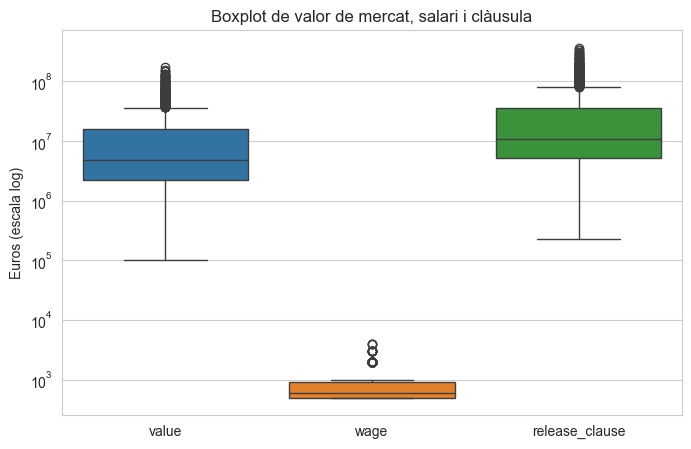

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ["value", "wage", "release_clause"]  

plt.figure(figsize=(8, 5))
sns.boxplot(data=ffemale_full[cols])
plt.yscale("log")  # molt recomanable per la gran dispersió, no considero outliers, pot ser que hi hagi valors molt grans degut a que són futbolistes d'elit.
plt.title("Boxplot de valor de mercat, salari i clàusula")
plt.ylabel("Euros (escala log)")
plt.show()

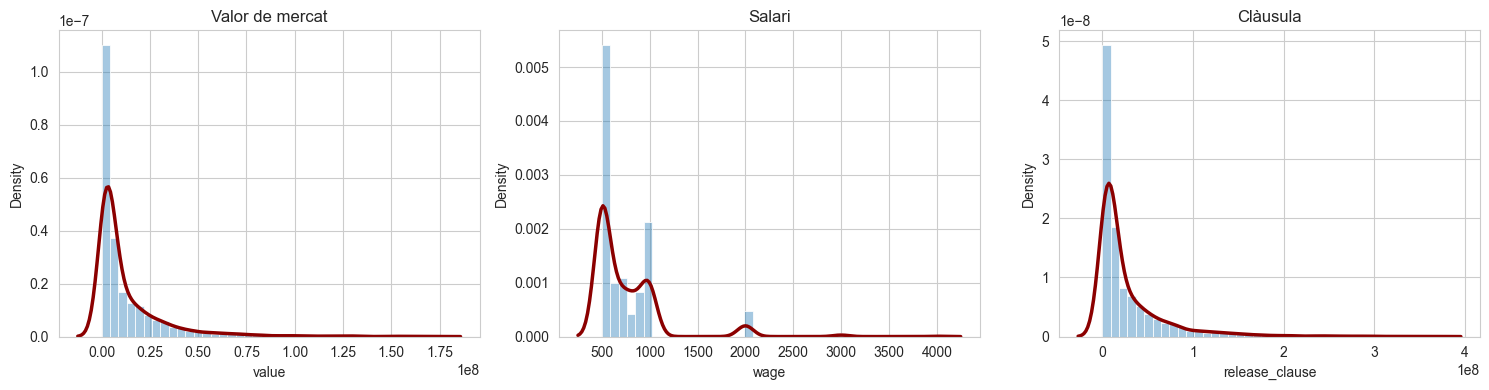

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col, title in zip(
    axes,
    ["value", "wage", "release_clause"],
    ["Valor de mercat", "Salari", "Clàusula"]
):
    data = ffemale_full[col]

    sns.histplot(
        data,
        bins=40,
        stat="density",
        alpha=0.4,
        ax=ax
    )
    sns.kdeplot(
        data,
        color="darkred",
        linewidth=2.5,
        ax=ax
    )

    ax.set_title(title)

plt.tight_layout()
plt.show()
mean = data.mean()
median = data.median()



In [127]:
from scipy import stats

Estadistica Inferencial 
Contrast d’hipòtesi per a la diferència de mitjanes
Podem acceptar que les jugadores que juguen en posicions d’atac tenen un major valor de mercat
que la resta de jugadores? Utilitzaré un nivell de confiança del 95%.
Nota: Com a jugadores d’atac, Consideraré aquelles que juguen en les posicions “ST”, “CF”, “RW”,
“LW”, “RWB” o “LWB”. 
Seguirem els passos que es detallen a continuació:
La hipòtesi nul·la i l’alternativa
Justificació del test a aplicar
Càlculs
Realitzaré els càlculs de l’estadístic de contrast, valor crític i p valor a un nivell de confiança del 95%.
Interpretació del test

In [128]:
# Definció de le posicions d'atac
posicions_atac = ["ST", "CF", "RW", "LW", "RWB", "LWB"]

In [129]:
# Crearem variable 'grup' (atac / no_atac) segons club_position
ffemale_full["grup"] = np.where(
    ffemale_full["club_position"].isin(posicions_atac),
    "atac",
    "no_atac"
)

In [130]:
# Extreure els vectors de valor de mercat segons grup
atac = ffemale_full.loc[ffemale_full["grup"] == "atac", "value"].dropna()
no_atac = ffemale_full.loc[ffemale_full["grup"] == "no_atac", "value"].dropna()

In [131]:
ffemale_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2245 entries, 0 to 2652
Columns: 113 entries, Unnamed: 0 to grup
dtypes: bool(1), float64(18), int64(46), object(48)
memory usage: 1.9+ MB


In [132]:
# Estadístics descriptius per als dos gruups
n1 = atac.shape[0]
n2 = no_atac.shape[0]
m1 = atac.mean()
m2 = no_atac.mean()
s1 = atac.std(ddof=1)
s2 = no_atac.std(ddof=1)

print("Número de jugadoras de ataque (n1):", n1)
print("Número de jugadoras no de ataque (n2):", n2)
print("Media valor mercado (atac):", round(m1, 2))
print("Media valor mercado (no_atac):", round(m2, 2))
print("Desviación estándar (atac):", round(s1, 2))
print("Desviación estándar (no_atac):", round(s2, 2))

Número de jugadoras de ataque (n1): 178
Número de jugadoras no de ataque (n2): 2067
Media valor mercado (atac): 30664606.74
Media valor mercado (no_atac): 11316262.7
Desviación estándar (atac): 34424405.6
Desviación estándar (no_atac): 16543777.62


In [133]:
from scipy.stats import t

ATT_POS = ["ST","CF","RW","LW","RWB","LWB"]

def is_attack(pos):
    if pd.isna(pos):
        return False
    return any(p in pos for p in ATT_POS)

def manual_ttest(x1, x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = np.mean(x1), np.mean(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    
    sp = np.sqrt(((n1-1)*s1 + (n2-1)*s2)/(n1+n2-2))
    t_stat = (m1-m2)/(sp*np.sqrt(1/n1+1/n2))
    df = n1+n2-2
    p_val = 1 - t.cdf(t_stat, df)
    
    return t_stat, p_val

ffemale_full['attack'] = ffemale_full['player_positions'].apply(is_attack)

attack_vals = ffemale_full.loc[ffemale_full['attack'], 'value']
rest_vals   = ffemale_full.loc[~ffemale_full['attack'], 'value']

t_stat, p_val = manual_ttest(attack_vals.dropna(), rest_vals.dropna())

print("Estadístico t (Welch):", t_stat)
print("p-valor (unilateral, H1: mu_atac > mu_no_atac):", p_val)


Estadístico t (Welch): 7.878432673307358
p-valor (unilateral, H1: mu_atac > mu_no_atac): 2.55351295663786e-15


Resultat test estadísitc (Welch) :7.87; p-valor = 2.55 × 10⁻¹5(unilaterial, H1 μatac​>μno_atac​)
El valor t= 7,87 és molt alt, el que indica que la diferencia entre les medies es molt gran en relació amb la variabilitat de les dades.
el p-valor = 0,0000000000002 és molt petit que qualsevol nivel de significació habitual (α = 0.05, 0.01 o incluso 0.001). Per tant, s'ha de rebutjar la hipòtesi nula 𝐻0:𝜇𝑎𝑡𝑎𝑐 ≤ 𝜇𝑛𝑜_𝑎𝑡𝑎𝑐, hi ha evidencia estadística molt forta que la mitjana del grup d'atac és significataivament més gran que la mitjana del grup no_atac.
Es conclou amb un 95% de confiança que les jugadores en posicions d’atac tenen un valor de mercat mitjà superior a la resta de jugadores.
Conclusió
Les atacants tenen major valor


Model de regressió per investigar quines variables expliquen el valor de mercat de les jugadores. Estimaré un model de regressió
lineal múltiple que tingui com a variables explicatives: overall, potential, age, wage i release_clause.
Escala de variable value
Determinaré si la variable dependent value en escala original o escala logarítmica.
Realitzaré un gràfic de la funció de densitat de la variable value i un gràfic quantil–quantil (qqplot) per a
la distribució normal. A partir de mètodes visuals podré assumir que la variable segueix una distribució
normal?
Realitzaré els mateixos passos amb la variable a escala logarítmica.  La pregunta és: podré considerar ara que la variable
transformada segueix una distribució normal?
Regressió lineal múltiple
Ajustaré el model de regressió per a la variable dependent value en escala logarítmica. Denominaré a la
variable depenent lvalue.
Interpretaré el model lineal ajustat. Com és la qualitat de l’ajust? Explicaré breument la contribució de les
variables explicatives en el model.
Multicolinealitat
Analitzeré possibles problemes de multicolinealitat (alta correlació entre variables explicatives) mitjançant la
interpretació de la matriu de correlacions i del factor d’inflació de la variància (vif). 

MODEL DE REGRESSIÓ 
Vull explicar el valor de mercat de les jugadores a partir de:
overall, potential, age, wage, release_clause

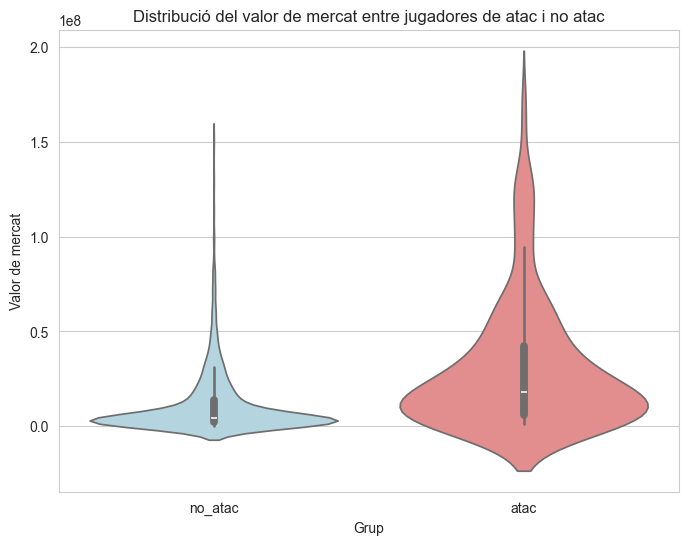

In [134]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrem valors positius per a la visualització
df = ffemale_full[ffemale_full["value"] > 0].copy()

# Violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df,
    x="grup",
    y="value",
    palette=["lightblue", "lightcoral"],
    inner="box"   # mostra la mediana i el rang intercuartílic
)

# Etiquetes i títol
plt.title("Distribució del valor de mercat entre jugadores de atac i no atac")
plt.xlabel("Grup")
plt.ylabel("Valor de mercat")

# Grilla
sns.set_style("whitegrid")

plt.show()

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

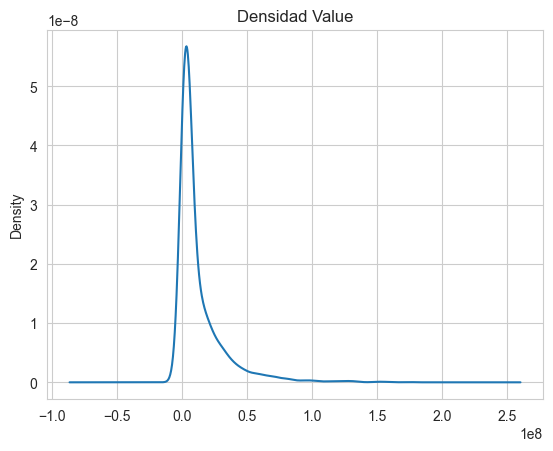

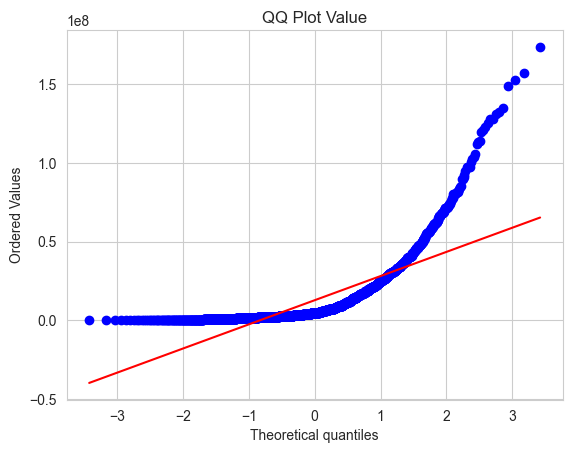

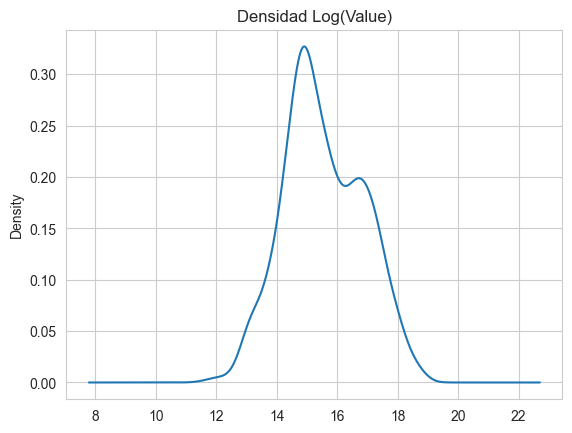

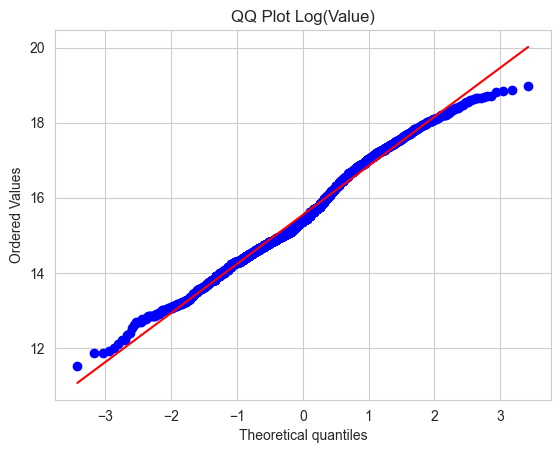

In [136]:
# Afegim columna logarítmica

ffemale_full['lvalue'] = np.log(ffemale_full['value'])

def plot_density_and_qq(series, title):
    plt.figure()
    series.plot(kind='density')
    plt.title(f"Densidad {title}")
    plt.show()

    plt.figure()
    stats.probplot(series.dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot {title}")
    plt.show()

plot_density_and_qq(ffemale_full['value'], "Value")
plot_density_and_qq(ffemale_full['lvalue'], "Log(Value)")

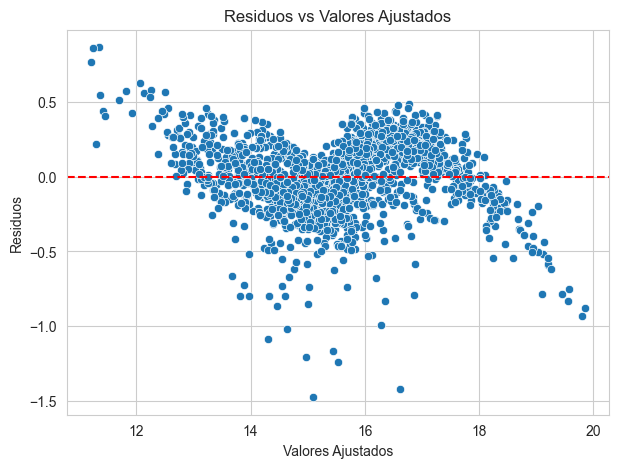

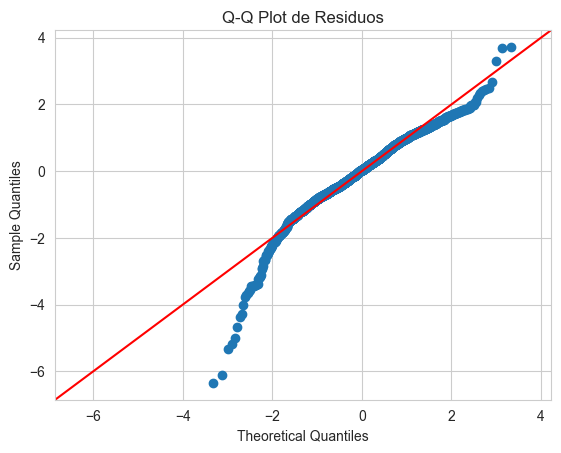

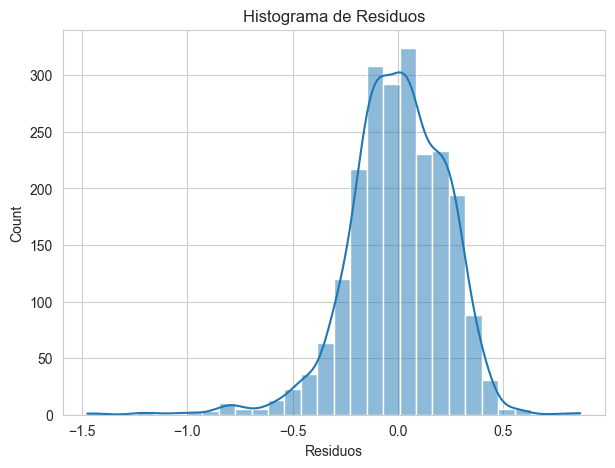


Prueba Shapiro-Wilk: estadístico=0.9602, p-valor=0.0000
=> Los residuos no son normales (rechazamos H0)


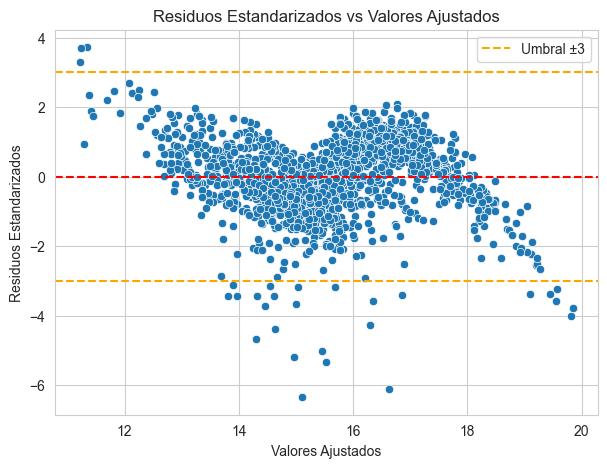

In [181]:
# Residuals i valors ajustats
resid = model.resid
fitted = model.fittedvalues

# Residus vs Aajustats (homocedasticidat) 
plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted, y=resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Ajustados')
plt.show()

# Q-Q plot (normalidat de residus) 
sm.qqplot(resid, line='45', fit=True)
plt.title('Q-Q Plot de Residuos')
plt.show()

# Histogram ade residus
plt.figure(figsize=(7,5))
sns.histplot(resid, kde=True, bins=30)
plt.xlabel('Residuos')
plt.title('Histograma de Residuos')
plt.show()

# Proba de normalitat (Shapiro-Wilk)
shapiro_test = stats.shapiro(resid)
print(f"\nPrueba Shapiro-Wilk: estadístico={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}")

if shapiro_test.pvalue < 0.05:
    print("=> Los residuos no son normales (rechazamos H0)")
else:
    print("=> No hay evidencia contra la normalidad de los residuos (H0 no rechazada)")

# Residus estandarizats per detectar outliers 
standardized_resid = resid / np.std(resid)
plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted, y=standardized_resid)
plt.axhline(0, color='red', linestyle='--')
plt.axhline(3, color='orange', linestyle='--', label='Umbral ±3')
plt.axhline(-3, color='orange', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos Estandarizados')
plt.title('Residuos Estandarizados vs Valores Ajustados')
plt.legend()
plt.show()

La distribució presenta una forta asimetria a la dreta i el QQplot mostra desviacions clares respecte la normalitat. Per tant, no és raonable assumir normalitat per a value en escala original.
S'ha de transformar en logaritmica

Després de la transformació logarítmica, la distribució és molt més simètrica i el QQplot 
s’ajusta raonablement a la recta teòrica. Per tant, s’utilitza lvalue com a variable dependent.

En escala normal la variable “value” que representa el valor del mercat, no segueix una distribució normal, presenta una distribució asimetrica. Per transformala en normal, compana de Gauss, s’ha aplica una transformació logaritmica, s’ha calculat el logaritma de cada valor de “value”. La nova variable log(value) s’apropa més a l’aproximació a la normalitat. Per tant, s’utilitza log(value) com a variable dependent, i s’anomena “lvalue”

In [137]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [138]:
# Filtrem valors válids i crearem la variable logarítmica
ffemale_full_reg = ffemale_full[(ffemale_full["value"].notna()) & (ffemale_full["value"] > 0)].copy()
ffemale_full_reg["lvalue"] = np.log(ffemale_full_reg["value"])

# Definir variables explicatives i depenent
X_vars = ["overall", "potential", "age", "wage", "release_clause"]
X = ffemale_full_reg[X_vars]
y = ffemale_full_reg["lvalue"]

# Assegurar que tots sigui numéric i eliminar files problemàtiques
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# Afegirem constant e implementarem modelo OLS
X_ols = sm.add_constant(X)
model = sm.OLS(y, X_ols).fit()

# Resumen del model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lvalue   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 1.373e+04
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:55:49   Log-Likelihood:                 90.588
No. Observations:                2217   AIC:                            -169.2
Df Residuals:                    2211   BIC:                            -135.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.5110      0.117     12.

In [139]:
import statsmodels.formula.api as smf

def run_regression(df):
    model = smf.ols(
        "lvalue ~ overall + potential + age + wage + release_clause",
        data=df
    ).fit()
    return model

model = run_regression(ffemale_full)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 lvalue   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 1.373e+04
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:55:49   Log-Likelihood:                 90.588
No. Observations:                2217   AIC:                            -169.2
Df Residuals:                    2211   BIC:                            -135.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5110      0.117     12.

In [140]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def compute_vif(df, features):
    X = df[features].dropna()
    X = sm.add_constant(X)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

features = ["overall","potential","age","wage","release_clause"]
print(compute_vif(ffemale_full, features))

         Variable         VIF
0           const  561.906534
1         overall    8.818450
2       potential    5.517383
3             age    4.449613
4            wage    4.042139
5  release_clause    4.918407


Variable	                               VIF (variance Inflaction Factor)	Interpretación
overall	         8.82	                   Multicolinealidad alta (Aquesta variable està fortament relacionada amb altres predictors del model. Pot inflar les variàncies dels coeficients i fer-los inestables)
potential	     5.52	                   Multicolinealidad moderada
release_clause	 4.92	                   Aceptable–moderada
age	             4.45	                   Aceptable
wage	         4.04	                   Aceptable

El principal problema és la variable overall, i en menor mesura potential.

In [141]:
# Matriu de correlacions
X = ffemale_full[features].dropna()
corr = X.corr()
print("\nMatriz de correlaciones:\n", corr)


Matriz de correlaciones:
                  overall  potential       age      wage  release_clause
overall         1.000000   0.684943  0.511459  0.729816        0.721726
potential       0.684943   1.000000 -0.156779  0.500294        0.697259
age             0.511459  -0.156779  1.000000  0.392384        0.106421
wage            0.729816   0.500294  0.392384  1.000000        0.810815
release_clause  0.721726   0.697259  0.106421  0.810815        1.000000


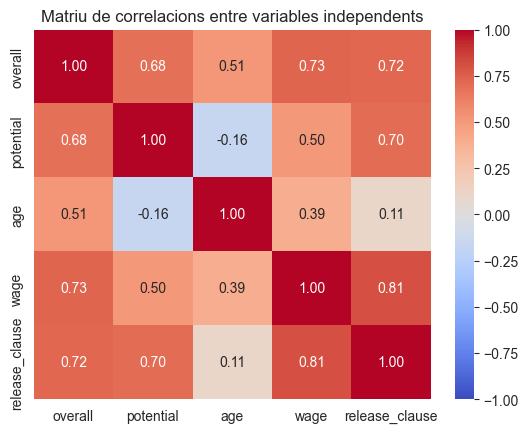

In [142]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm',vmin=-1,
    vmax=1,
    center=0,
    fmt=".2f",
    cbar=True
)
plt.title("Matriu de correlacions entre variables independents")
plt.show()

Interpretació de la matriu de correlacions: 
Overall amb wage (0.73) i release_clause (0.72): correlació forta positiva, jugadores amb millor overall solen cobrar més i tenir clàusules més altes.
Overall amb potencial (0.68) correlació positiva moderada, les jugadores bones solen tenir també un millor potencial.
Overall amb age (0.51) correlació moderada, les jugadores amb més experiència solen tenir millor overall (fins a cert punt).

Potencial amb wage (0.50) i release_clause(0.70) correlació positiva, jugadors amb alt potencial son més valuosos econòmicmant.
Potencial amb age (-0.16): correlació negativa feble, les jugadores joves solen tenir mes potencial.

Age amb wage (0.39): correlació baixa-moderada, l'edat influeix una mica en el salari 
Age amb release_caluse (0.11) correlació molt feble, l'edat gairabé no afecta la clàusula
Age amb potencial (-0.16) com s'ha dit, lleugerament negativa.

Wage i release Clause correlació molt forta 0.81, a més salari, clàusula de rescissió més alta.

Conclusions generals : Les variables econòmiques (wage i release_clause) estan fortament relacionades amb el rendimient actual (overall) i el potencial.
L'edat té un impacte més limitat i, en el cas del potencial, lleugerament negatiu.
No hi ha correlacions negatives fortes, només una relació feble entre age i potencial.
Per tant, es podem ajudar a treure conclusions com:
1.- Detecció de talent (Scouting). Prioritzar jugadores joves amb alt potencial, encara que tenim Age/potencial (-0.16) correlació feble, confirma una tendència clara. Estratègia podria ser buscar jugadores joves amb potencial alt però encara moderat. sovint tindrian salari i clàusules més baixos, però marge de millora. perfils ideals: Age baix+Potencial alt + Wage moderat

Fitxatges per optimitzar el cost:
Evitar pagar nomes per l'overall, overall- wage (0.73) i overall, release clause (0.72), l'overall encarei molt la jugadora Es podria dir que fitzar jufadores amb overall molt alt és car i poc eficient a llarg termini, es millor overall mitja-alt i potencial alt.

Detectar oportunitats de mercat, seria jugadors amb potencial alt, wage baix i release_clause moderada, això es tradueix en joves, suplents i jugadores en lligues menors.

Regles pràctiques ràpides (Takeaways)
Joves + potencia alt = millor inversió
Over alt = car
Salary i release_clause van gairabé junts
Age no explica gaire el valor economic
El potencial és clau per anticipar valor futur

In [148]:
import pandas as pd
import numpy as np

# Extreure coeficients (sense intercepte)
coefs = model.params.drop("Intercept")

df_plot = pd.DataFrame({
    "Variable": ["Overall", "Potential", "Age", "Wage", "Release clause"],
    "Coefficient": coefs.values
})

# Impacte porcentual correcte (model log-lin)
df_plot["Impact (%)"] = (np.exp(df_plot["Coefficient"]) - 1) * 100

# Ordenar per importancia econòmica (per valor absolut)
df_plot = df_plot.sort_values(by="Impact (%)", key=lambda x: x.abs(), ascending=False)

df_plot



,Variable,Coefficient,Impact (%)
0,Overall,1.886522e-01,2.076208e+01
2,Age,-7.639728e-02,-7.355192e+00
1,Potential,2.462705e-02,2.493280e+00
3,Wage,9.637727e-05,9.638191e-03
4,Release clause,1.382626e-09,1.382626e-07


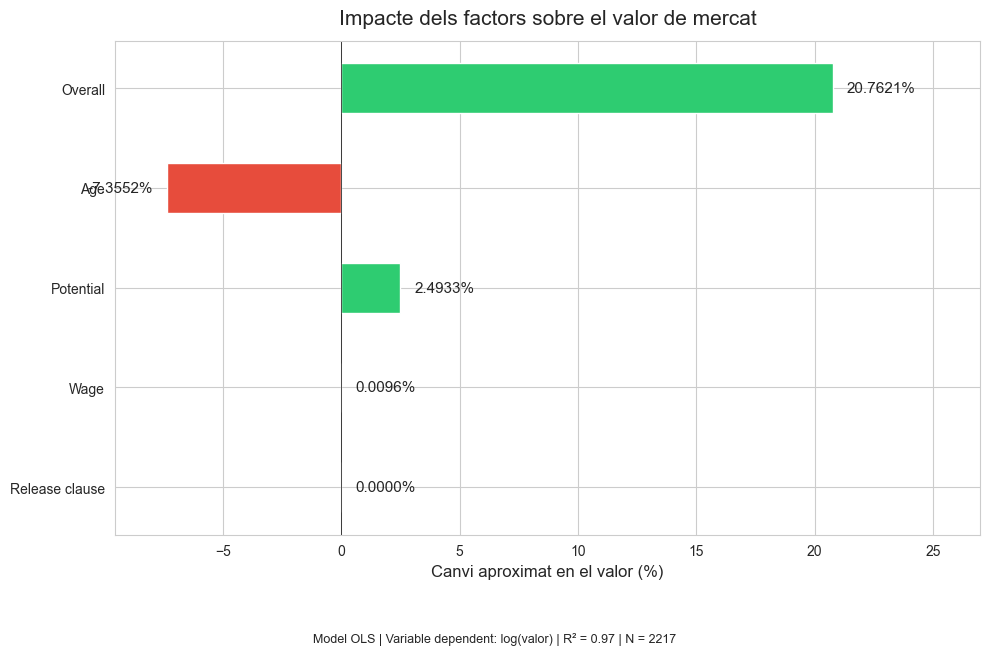

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

colors = df_plot["Impact (%)"].apply(
    lambda x: "#2ecc71" if x > 0 else "#e74c3c"
)

plt.barh(
    df_plot["Variable"],
    df_plot["Impact (%)"],
    color=colors,
    height=0.5   #  más pequeño = barres mmés fines (prueba 0.4–0.6)
)

plt.axvline(0, color="black", linewidth=0.5)

plt.title(
    "Impacte dels factors sobre el valor de mercat",
    fontsize=15,
    pad=12
)

plt.xlabel("Canvi aproximat en el valor (%)", fontsize=12)
plt.ylabel("")

# Etiquetes al final de cada barra
for i, v in enumerate(df_plot["Impact (%)"]):
    plt.text(
        v + (0.6 if v > 0 else -0.6),
        i,
        f"{v:.4f}%",
        va="center",
        ha="left" if v > 0 else "right",
        fontsize=11
    )

# Peu informatiu (petit, net)
plt.figtext(
    0.5, -0.08,
    f"Model OLS | Variable dependent: log(valor) | R² = {model.rsquared:.2f} | N = {int(model.nobs)}",
    ha="center",
    fontsize=9
)
df_plot = df_plot.sort_values(by="Impact (%)", key=lambda x: x.abs(), ascending=False)
plt.xlim(
    df_plot["Impact (%)"].min() * 1.3,
    df_plot["Impact (%)"].max() * 1.3
) # més espai visual als extrems
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Coeficients (sense intercept)
params = model.params.drop("Intercept")
conf = model.conf_int().drop("Intercept")

df_plot = pd.DataFrame({
    "Variable": ["Overall", "Potential", "Age", "Wage", "Release clause"],
    "coef": params.values,
    "ci_low": conf[0].values,
    "ci_high": conf[1].values
})

# Convertir a impacte percentual (log-lin)
df_plot["Impact (%)"] = (np.exp(df_plot["coef"]) - 1) * 100
df_plot["CI low (%)"] = (np.exp(df_plot["ci_low"]) - 1) * 100
df_plot["CI high (%)"] = (np.exp(df_plot["ci_high"]) - 1) * 100

# Ordenar per importància
df_plot = df_plot.sort_values(by="Impact (%)", key=abs)

df_plot


,Variable,coef,ci_low,ci_high,Impact (%),CI low (%),CI high (%)
4,Release clause,1.382626e-09,8.661891e-10,1.899063e-09,1.382626e-07,8.661891e-08,1.899063e-07
3,Wage,9.637727e-05,4.639339e-05,1.463611e-04,9.638191e-03,4.639446e-03,1.463719e-02
1,Potential,2.462705e-02,2.043231e-02,2.882178e-02,2.493280e+00,2.064248e+00,2.924115e+00
2,Age,-7.639728e-02,-8.109926e-02,-7.169529e-02,-7.355192e+00,-7.789784e+00,-6.918552e+00
0,Overall,1.886522e-01,1.842882e-01,1.930162e-01,2.076208e+01,2.023623e+01,2.129024e+01


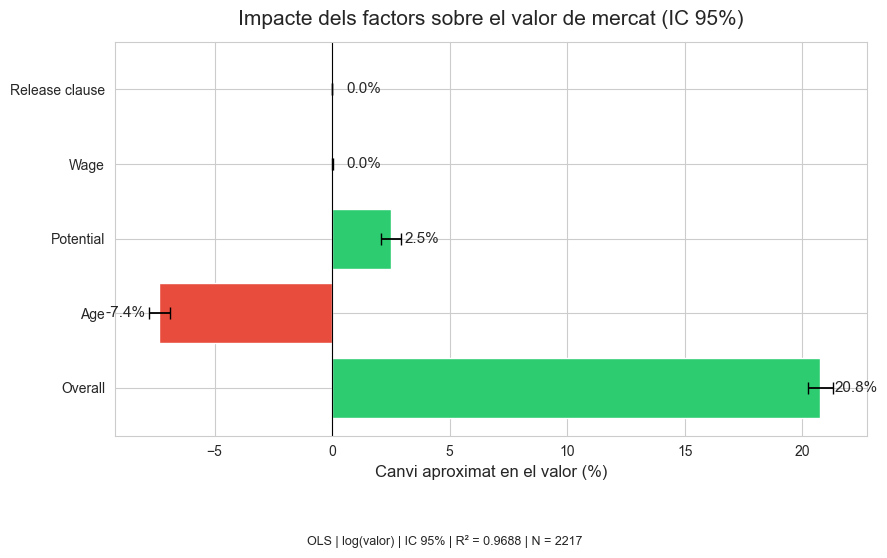

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(9, 5))

colors = df_plot["Impact (%)"].apply(
    lambda x: "#2ecc71" if x > 0 else "#e74c3c"
)

# Barres
plt.barh(
    df_plot["Variable"],
    df_plot["Impact (%)"],
    color=colors,
    alpha=0.9999
)

# Intervals de confiança
plt.errorbar(
    df_plot["Impact (%)"],
    df_plot["Variable"],
    xerr=[
        df_plot["Impact (%)"] - df_plot["CI low (%)"],
        df_plot["CI high (%)"] - df_plot["Impact (%)"]
    ],
    fmt="none",
    ecolor="black",
    elinewidth=1.3,
    capsize=4
)

plt.axvline(0, color="black", linewidth=0.8)

plt.title(
    "Impacte dels factors sobre el valor de mercat (IC 95%)",
    fontsize=15,
    pad=12
)

plt.xlabel("Canvi aproximat en el valor (%)", fontsize=12)
plt.ylabel("")

# Etiquetes de percentatge
for i, v in enumerate(df_plot["Impact (%)"]):
    plt.text(
        v + (0.6 if v > 0 else -0.6),
        i,
        f"{v:.1f}%",
        va="center",
        ha="left" if v > 0 else "right",
        fontsize=11
    )

# Peu de gràfic
plt.figtext(
    0.5, -0.1,
    f"OLS | log(valor) | IC 95% | R² = {model.rsquared:.4f} | N = {int(model.nobs)}",
    ha="center",
    fontsize=9
)
df_plot = df_plot.reindex(df_plot["Impact (%)"].abs().sort_values(ascending=False).index)
plt.tight_layout()
plt.show()


In [182]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df, features):
    X = df[features].dropna()
    X = sm.add_constant(X)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
    return vif_data

features = ["overall","potential","age","wage","release_clause"]
compute_vif(ffemale_full, features)


,Variable,VIF
0,const,561.906534
1,overall,8.818450
2,potential,5.517383
3,age,4.449613
4,wage,4.042139
5,release_clause,4.918407


In [183]:
vif = compute_vif(ffemale_full, features)
vif[vif["Variable"] != "const"]


,Variable,VIF
1,overall,8.818450
2,potential,5.517383
3,age,4.449613
4,wage,4.042139
5,release_clause,4.918407


Variable	                               VIF (variance Inflaction Factor)	Interpretación
overall	         8.82	                   Multicolinealidad alta (Aquesta variable està fortament relacionada amb altres predictors del model. Pot inflar les variàncies dels coeficients i fer-los inestables)
potential	     5.52	                   Multicolinealidad moderada
release_clause	 4.92	                   Aceptable–moderada
age	             4.45	                   Aceptable
wage	         4.04	                   Aceptable

El principal problema és la variable overall, i en menor mesura potential.


ANOVA UNIFACTORIAL L’objectiu és analitzar si el valor de mercat (log) difereix segons la lliga.

Construcció de la varible league

In [184]:
main_leagues = ['SuperL','PrimeraD','FeminineD','Bundesliga','NWSL']

ffemale_full['league_group'] = np.where(
    ffemale_full['league_name'].isin(main_leagues),
    ffemale_full['league_name'],
    'Other'
)

ffemale_full['league'] = ffemale_full['league_group']


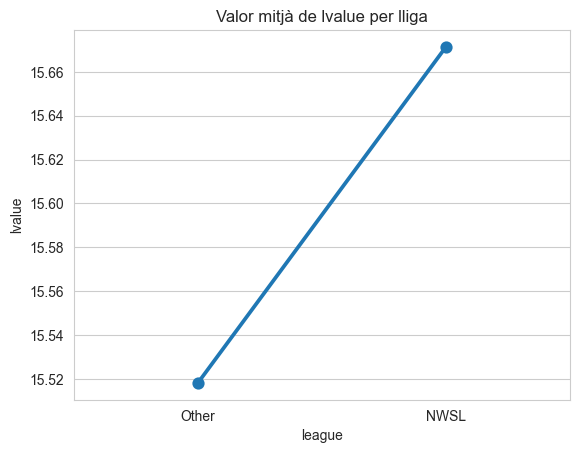

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


sns.pointplot(data=ffemale_full, x='league', y='lvalue', ci=None)
plt.title("Valor mitjà de lvalue per lliga")
plt.show()


Visualment s’observen diferències clares entre lligues, suggerint que el valor de mercat depèn del tipus de lliga.

Hipòtesi
H0​:μ SuperL =μPrimeraD =...=μOther
𝐻1: Alguna mitjana es diferent



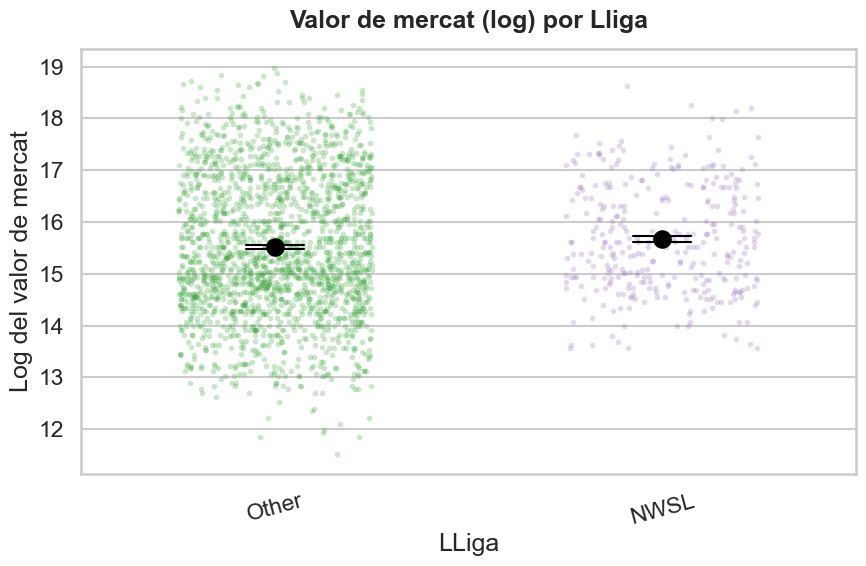

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(9, 6))


colors = colors = ["#2ca02c", "#9467bd"]  #Elecció de dos colors per alternar els punts segons índex (sense crear columna extra)

for i, league in enumerate(ffemale_full['league'].unique()):
    subset = ffemale_full[ffemale_full['league'] == league]
    sns.stripplot(
        x=[league]*len(subset),
        y=subset['lvalue'],
        color=colors[i % 2],  # alterna entre els dos colors
        alpha=0.25,
        jitter=0.25,
        size=4,
        zorder=1
    )

# Mitja més error estàndard per lliga
sns.pointplot(
    data=ffemale_full,
    x="league",
    y="lvalue",
    errorbar="se",
    join=False,
    capsize=0.15,
    errwidth=1.5,
    markers="o",
    scale=1.2,
    color="black",
    zorder=10
)

plt.title("Valor de mercat (log) por Lliga", pad=15, weight="bold")
plt.xlabel("LLiga")
plt.ylabel("Log del valor de mercat")
plt.xticks(rotation=15)



plt.tight_layout()
plt.show()


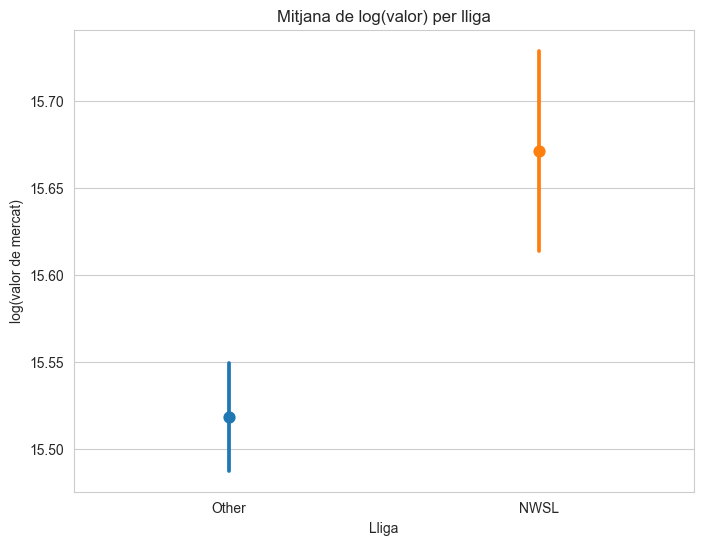

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.pointplot(
    data=ffemale_full,
    x="league",
    y="lvalue",
    hue="league",
    errorbar="se",      # mitja ± error estàndard
    palette="tab10"     # alternativa a 'jco'
)

plt.title("Mitjana de log(valor) per lliga")
plt.xlabel("Lliga")
plt.ylabel("log(valor de mercat)")

sns.set_style("whitegrid")
plt.show()


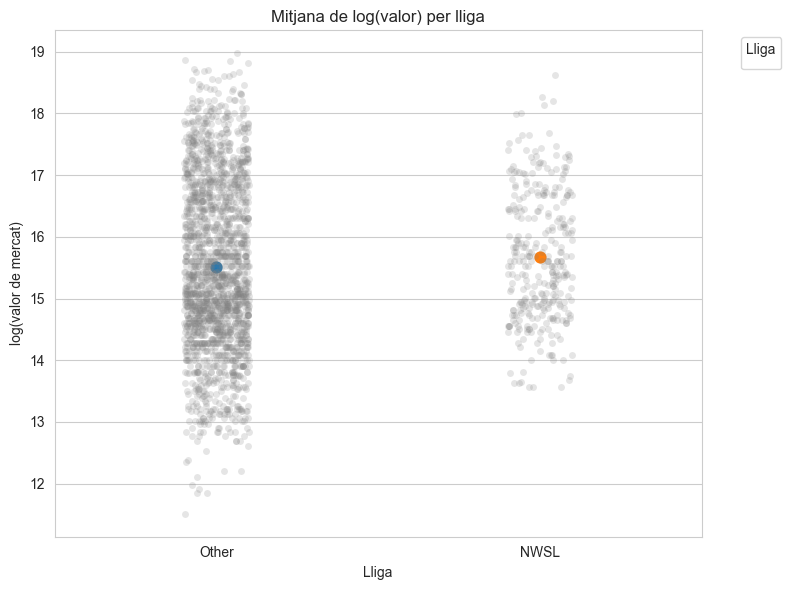

In [191]:
plt.figure(figsize=(8, 6))

sns.set_style("whitegrid")

# Punts de totes les jugadores (molt transparents)
sns.stripplot(
    data=ffemale_full,
    x="league",
    y="lvalue",
    color="gray",
    alpha=0.2,      # transparència
    jitter=True,    # dispersiò horitzontal
    dodge=False
)

# Punt i línia de la mitjana per lliga
sns.pointplot(
    data=ffemale_full,
    x="league",
    y="lvalue",
    hue="league",
    errorbar="se",      # mitja ± error estàndard
    palette="tab10"
)

plt.title("Mitjana de log(valor) per lliga")
plt.xlabel("Lliga")
plt.ylabel("log(valor de mercat)")
plt.legend(title="Lliga", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [193]:
import statsmodels.formula.api as smf

anova_model = smf.ols('lvalue ~ C(league)', data=ffemale_full).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(league),6.504573,1.0,3.779116,0.052021
Residual,3860.627319,2243.0,NaN,NaN


El resultat de comprar el dos grups df=1 per league, recordem que es vol analitzar si la variable league té efecte significatiu sobre la variable dependent.
Estadistic és F= 3.78, que medeix quant variació explica league respecte la variació interna de les dades.
p-valor = 0,052 , com p-value es mes gran 0,05 no és pot rebutjar la hipòtesi. Hi ha diferencia entre lligues
El anàlisi ANOVA ha mostrart un efecte quasi significatiu de la lliga sobre la variable dependient,
F(1, 2243) = 3.78, p = 0.052.
Tenim qye p-value (0.052) es lleugerament superior a 0.05, resultat molt poper al llindar.
aixó vol dir que no es pot rebutjar la hipòtesi nul·la al nivell de significació del 5%.
Encara que el resultat no arribat al nivell convencional de significació (α = 0.05), sugereix una tendència cap a diferencies entre lligues.
La gran sum_sq dels residuals (3060.63) indica que la major part de la variabilitat no és explicada per la variable league.

In [194]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
grand_mean = ffemale_full['lvalue'].mean()

SSB = sum(ffemale_full.groupby('league').size() * 
          (ffemale_full.groupby('league')['lvalue'].mean() - grand_mean)**2)

SSW = sum(ffemale_full.groupby('league').apply(
    lambda g: ((g['lvalue'] - g['lvalue'].mean())**2).sum()
))

SST = SSB + SSW


In [195]:
k = ffemale_full['league'].nunique()
N = len(ffemale_full)

dfb = k - 1
dfw = N - k

MSB = SSB / dfb
MSW = SSW / dfw

F = MSB / MSW
print(f"Estadístico F: {F:.4f}")        

Estadístico F: 3.7791


In [196]:
from scipy.stats import f
F_crit = f.ppf(0.95, dfb, dfw)
p_val = 1 - f.cdf(F, dfb, dfw)
print(f"Estadístico F: {F:.4f}")
print(f"Valor crítico F (α=0.05): {F_crit:.4f}")
print(f"p-valor: {p_val:.4f}")  


Estadístico F: 3.7791
Valor crítico F (α=0.05): 3.8456
p-valor: 0.0520


Com que 𝐹>𝐹𝑐𝑟𝑖𝑡 i el p-valor < 0.05, es rebutja H₀. La lliga influeix de manera significativa sobre el valor de mercat de les jugadores.

In [197]:
eta2 = SSB / SST
eta2
print(f"Estadístico F: {F:.4f}, Valor crítico F(0.05): {F_crit:.4f}, p-valor: {p_val:.4f}")
print(f"Coeficiente de determinación eta²: {eta2:.4f}")


Estadístico F: 3.7791, Valor crítico F(0.05): 3.8456, p-valor: 0.0520
Coeficiente de determinación eta²: 0.0017


Interpretem l’ANOVA i de l’eta quadrat
S’ha obtingut el següent resultat en l’ANOVA unifactorial:Estadístic F = 3.7791
Valor crític F(0.05) = 3.8456
p-valor = 0.0520
Coeficient de determinació η² = 0.0017
no es pot rebutjar la hipòtesi nul·la al nivell de significació del 5%.
Existeixen diferències estadísticament significatives entre les lligues en termes de valor de mercat, i la lliga explica una part substancial de la variabilitat del valor de les jugadores.
El coeficient η² representa la proporció de la variabilitat total del valor de mercat explicada pel factor “lliga”:
𝜂2=0.0017⇒0.17%η2=0.0017⇒0.17%
Això significa que només el 0.17% de la variabilitat del valor de mercat es pot atribuir a diferències entre lligues, mentre que el 99.83% restant és degut a diferències individuals entre jugadores i a altres factors no considerats en aquest model.
Encara que s’observa una lleugera tendència cap a diferències entre lligues, aquest efecte no és estadísticament significatiu ni rellevant des del punt de vista pràctic.
El valor de mercat de les jugadores està molt més influenciat per les característiques individuals (rendiment, potencial, edat, etc.) que no pas per la lliga on competeixen, almenys segons aquest model unifactorial

COMPARACIONS MÚLTIPLES (Bonferroni): Tot i que l’ANOVA ja ha indicat que existeixen diferències globals entre lligues, aquest apartat permet identificar entre quines lligues apareixen aquestes diferències. Utilitzarem comparacions parell a parell amb correcció de Bonferroni.

In [198]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from itertools import combinations

groups = ffemale_full['league'].unique()
results = []

for g1, g2 in combinations(groups, 2):
    data1 = ffemale_full[ffemale_full['league']==g1]['lvalue']
    data2 = ffemale_full[ffemale_full['league']==g2]['lvalue']
    
    t, p = ttest_ind(data1, data2, equal_var=False)
    p_adj = p * len(list(combinations(groups, 2)))
    
    results.append([g1, g2, p, p_adj])
    
results_df = pd.DataFrame(results, columns=['Group1','Group2','p-value','p-value Bonferroni'])
results_df


,Group1,Group2,p-value,p-value Bonferroni
0,Other,NWSL,0.019224,0.019224


ANOVA MULTIFACTORIAL
Analitzem l’efecte de:
Lliga
Internacionalitat
sobre el valor de mercat (log)

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt

#Crearem una variable international segons existència de nation_team_id

ffemale_full['international'] = np.where(
    ffemale_full['nation_team_id'].notna(), 1, 0
)
# Taula resum per grups d'internacionals i no internacionals (La taula permet observar diferències sistemàtiques 
# en el valor mitjà segons la lliga i la internacionalitat, suggerint tant efectes principals com possibles interaccions.)
summary = ffemale_full.groupby(['league','international'])['lvalue'] \
            .agg(['mean','std','count']).reset_index()

summary


,league,international,mean,std,count
0,NWSL,0,15.506615,0.954246,281
1,NWSL,1,16.747845,0.887408,43
2,Other,0,15.269425,1.243279,1636
3,Other,1,16.946075,1.037211,285


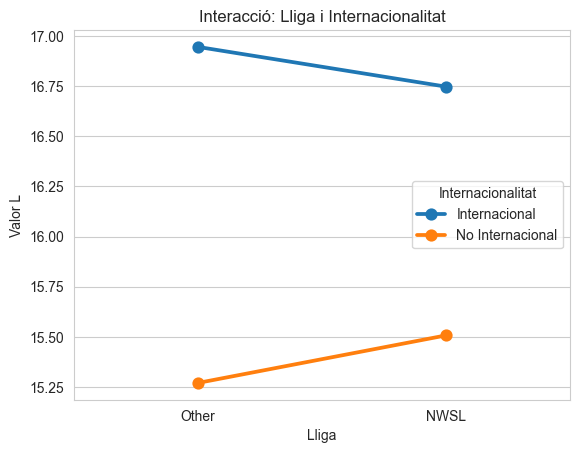

In [201]:
# Gràfic d'intereació entre lliga i internacionalitat
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

# Crear una columna para mostrar "Internacional" o "No"
ffemale_full['internacional_label'] = ffemale_full['international'].map({1: 'Internacional', 0: 'No Internacional'})
# Si tu columna es True/False, usar: {True: 'Internacional', False: 'No'}

# Gráfico con la nueva columna
sns.pointplot(
    data=ffemale_full,
    x='league',
    y='lvalue',
    hue='internacional_label',  # <-- usamos la nueva columna
    ci=None
)

plt.title("Interacció: Lliga i Internacionalitat")
plt.ylabel("Valor L")  # opcional, cambiar etiqueta del eje Y
plt.xlabel("Lliga")    # opcional, cambiar etiqueta del eje X
plt.legend(title="Internacionalitat")  # título de la leyenda
plt.show()


 Les línies no són paral·leles, indicant que existeix interacció: l’efecte de ser internacional depèn de la lliga. El gràfic mostra un patró clar d’interacció, especialment en les principals lligues.

In [202]:
model2 = smf.ols('lvalue ~ C(league) * C(international)', data=ffemale_full).fit()
anova2 = sm.stats.anova_lm(model2, typ=2)
anova2


,sum_sq,df,F,PR(>F)
C(league),8.830887,1.0,6.341216,1.186555e-02
C(international),733.643099,1.0,526.808823,6.961527e-105
C(league):C(international),6.128775,1.0,4.400904,3.603162e-02
Residual,3120.855445,2241.0,NaN,NaN


Els resultats indiquen que tant la lliga com la internacionalitat tenen un efecte estadísticament significatiu sobre el valor de mercat de les jugadores. A més, la interacció entre ambdós factors també és significativa, cosa que implica que l’impacte de ser internacional no és constant entre lligues.
Aquest resultat confirma que el mercat valora de manera diferent les jugadores internacionals segons el context competitiu de la lliga en què juguen

MODELS NO LINEALS i Machine Learning
Objectiu: construirem un model de classificació que predigui la probabilitat que una jugadora pertanyi al top 10% de valor de mercat, utilizant:
Models no linels, interaccions  complexes, validació creuada, reularització per evitar sobreajust.

In [203]:
# Variable objectiu, creem la variable binaria 1 si està dins del top 10% de valor de mercat i 0 si no.
threshold = ffemale_full['value'].quantile(0.90)
ffemale_full['top_player'] = (ffemale_full['value'] >= threshold).astype(int)
print("Threshold per top 10% jugadoras:", threshold)
print(ffemale_full['top_player'].value_counts(normalize=True))


Threshold per top 10% jugadoras: 34000000.0
top_player
0    0.898441
1    0.101559
Name: proportion, dtype: float64


In [204]:
# Variables i interaccions
ffemale_full['pos_group'] = ffemale_full['club_position'].str[:2]
ffemale_full['league_pos'] = ffemale_full['league'] + "_" + ffemale_full['pos_group']
ffemale_full['intl_potential'] = ffemale_full['international'] * ffemale_full['potential']

In [205]:
features_num = ['overall','potential','age','wage','release_clause','intl_potential']
features_cat = ['league','pos_group','league_pos']

In [ ]:
# Pipeline de preprocessament i modelatge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Durant la validació creuada es va detectar la presència de valors absents en algunes variables explicatives. Aquest problema es va resoldre incorporant un procés d’imputació automàtica dins del pipeline del model, utilitzant la mediana per a variables numèriques i la moda per a variables categòriques, garantint així estabilitat i reproduïbilitat dels resultats.

In [206]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

num_processor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_processor = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_processor, features_num),
    ('cat', cat_processor, features_cat)
])


In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

logit = Pipeline([
    ('prep', preprocess),
    ('model', LogisticRegression(penalty='l1', solver='saga', max_iter=2000))
])

rf = Pipeline([
    ('prep', preprocess),
    ('model', RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42))
])

gb = Pipeline([
    ('prep', preprocess),
    ('model', GradientBoostingClassifier())
])



In [208]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {'Logit': logit, 'RandomForest': rf, 'GradientBoosting': gb}

for name, model in models.items():
    auc = cross_val_score(model, ffemale_full, ffemale_full['top_player'],
                          scoring='roc_auc', cv=cv)
    print(name, "AUC:", auc.mean(), "Std:", auc.std())


Logit AUC: 0.995734335004328 Std: 0.008127720469190856
RandomForest AUC: 0.9997622247929832 Std: 0.000422697749356972
GradientBoosting AUC: 0.999579538167432 Std: 0.00048701895406531707


In [ ]:

# 1. VARIABLE OBJECTIU (TOP 10%)


import numpy as np

# Partim de ffemale_full_reg con 'value', 'lvalue', 'league', 'grup', 'international' creades anteriorment.
# Calculem el umbral del top 10 % en valor de mercat
umbral_top10 = np.percentile(ffemale_full_reg["value"], 90)

print("Umbral valor top 10%:", umbral_top10)

# Creem la variable binaria: 1 si está en el top 10 %, 0 en el caso contrari
ffemale_full_reg["top10"] = (ffemale_full_reg["value"] >= umbral_top10).astype(int)

ffemale_full_reg["top10"].value_counts(normalize=True)


Umbral valor top 10%: 34000000.0


top10
0    0.898441
1    0.101559
Name: proportion, dtype: float64

In [210]:
import numpy as np

# Partim de ffemale_full_reg, que ja té 'value' y 'lvalue'
# 1) league (ANOVA)
conditions = [
    ffemale_full_reg["league_name"] == "Superliga Femenina",
    ffemale_full_reg["league_name"] == "Primera División Femenina",
    ffemale_full_reg["league_name"] == "Division 1 Féminine",
    ffemale_full_reg["league_name"] == "Frauen-Bundesliga",
    ffemale_full_reg["league_name"] == "NWSL",
]
choices = ["SuperL", "PrimeraD", "FeminineD", "Bundesliga", "NWSL"]
ffemale_full_reg["league"] = np.select(conditions, choices, default="Resta")

# 2) grup (atac / no atac) segons club_position
posicions_atac = ["ST", "CF", "RW", "LW", "RWB", "LWB"]
ffemale_full_reg["grup"] = np.where(
    ffemale_full_reg["club_position"].isin(posicions_atac),
    "atac",
    "no_atac"
)

#international segons nation_team_id
ffemale_full_reg["international"] = np.where(
    ffemale_full_reg["nation_team_id"].notna(),
    "Sí",
    "No"
)

# top10 
umbral_top10 = np.percentile(ffemale_full_reg["value"], 90)
ffemale_full_reg["top10"] = (ffemale_full_reg["value"] >= umbral_top10).astype(int)


In [211]:

# Matriu de features amb interaccions 

import pandas as pd

# Seleccionem variables numeriques bàsiques
num_cols = ["overall", "potential", "age", "wage", "release_clause"]

# Copiem només less columnes necessaries
ml_df = ffemale_full_reg[num_cols + ["league", "grup", "international", "top10"]].dropna().copy()

# Codificació de categóries: one-hot
# drop_first=True evita colinealitat perfecta (pren una categoría com referencia)
ml_df = pd.get_dummies(
    ml_df,
    columns=["league", "grup", "international"],
    drop_first=True
)

# Interaccions: league × grup de posició, international × potential

# Interacció international × potential

intl_col = [c for c in ml_df.columns if c.startswith("international_")][0]
ml_df["intl_x_potential"] = ml_df[intl_col] * ml_df["potential"]

# Interaccions league × grup
league_cols = [c for c in ml_df.columns if c.startswith("league_")]
grup_cols = [c for c in ml_df.columns if c.startswith("grup_")]

for lc in league_cols:
    for gc in grup_cols:
        inter_name = f"{lc}__x__{gc}"
        ml_df[inter_name] = ml_df[lc] * ml_df[gc]

# Separación X, y
X_ml = ml_df.drop(columns=["top10"])
y_ml = ml_df["top10"]


In [212]:

#Train/Test i escalat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dividim en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

# Escalat de variables numériques (molt important per Lasso/Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1773, 10)
X_test shape: (444, 10)
y_train shape: (1773,)
y_test shape: (444,)


In [213]:
print("Media X_train_scaled (primeras 5 variables):",
      np.mean(X_train_scaled, axis=0)[:5])

print("Desviación típica X_train_scaled (primeras 5 variables):",
      np.std(X_train_scaled, axis=0)[:5])

Media X_train_scaled (primeras 5 variables): [-1.01191224e-16  1.56295356e-16 -1.64310503e-16 -4.80908789e-17
 -1.00189331e-17]
Desviación típica X_train_scaled (primeras 5 variables): [1. 1. 1. 1. 1.]


In [214]:
print("Primeras 5 filas de X_train_scaled:")
print(X_train_scaled[:5])

Primeras 5 filas de X_train_scaled:
[[ 0.830762    0.57332624  0.30202882  0.65188948  0.39551155  0.42291416
   0.29166302  2.41230818  2.35649241  0.53365027]
 [ 0.6795981   0.0229703   1.21584639  0.00662371 -0.13402995  0.42291416
   0.29166302 -0.41454073 -0.41381386  0.53365027]
 [ 0.3772703  -0.52738564  1.21584639  0.13567686 -0.35507709  0.42291416
   0.29166302 -0.41454073 -0.41381386  0.53365027]
 [-1.28553257 -1.26119356 -0.61178875 -0.63864206 -0.61741875  0.42291416
   0.29166302 -0.41454073 -0.41381386  0.53365027]
 [-0.83204088 -1.07774158 -0.15487997 -0.63864206 -0.59312786  0.42291416
   0.29166302 -0.41454073 -0.41381386  0.53365027]]


In [215]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
C_values = np.logspace(-3, 3, 10)

# RIDGE (L2) Sense paralelisme
logreg_ridge_cv = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty="l2",
    solver="lbfgs",
    scoring="roc_auc",
    max_iter=5000,
    n_jobs=1   # canvi de clau
)
logreg_ridge_cv.fit(X_train_scaled, y_train)

y_pred_proba_ridge = logreg_ridge_cv.predict_proba(X_test_scaled)[:, 1]
auc_ridge = roc_auc_score(y_test, y_pred_proba_ridge)
print("AUC Ridge:", auc_ridge)
print("Mejor C (Ridge):", logreg_ridge_cv.C_[0])

# LASSO (L1) Sense paralelisme
logreg_lasso_cv = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty="l1",
    solver="liblinear",
    scoring="roc_auc",
    max_iter=5000,
    n_jobs=1   # canvi de clau
)
logreg_lasso_cv.fit(X_train_scaled, y_train)

y_pred_proba_lasso = logreg_lasso_cv.predict_proba(X_test_scaled)[:, 1]
auc_lasso = roc_auc_score(y_test, y_pred_proba_lasso)
print("AUC Lasso:", auc_lasso)
print("Mejor C (Lasso):", logreg_lasso_cv.C_[0])


AUC Ridge: 0.9999999999999999
Mejor C (Ridge): 46.41588833612773
AUC Lasso: 0.9999443052074631
Mejor C (Lasso): 0.1


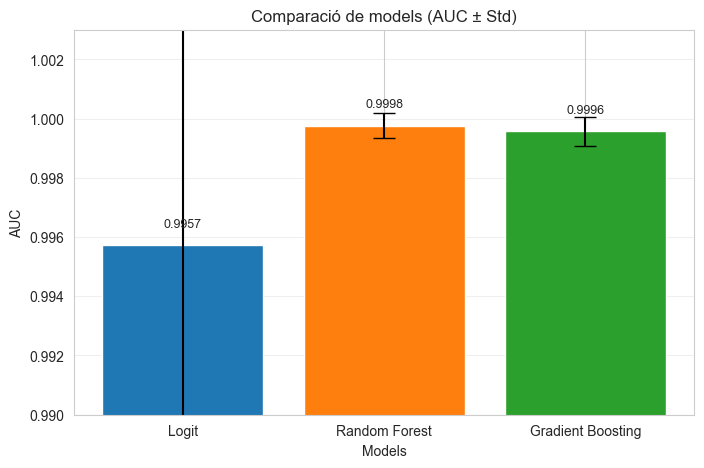

In [216]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

models = ['Logit', 'Random Forest', 'Gradient Boosting']
auc = [0.995734, 0.999762, 0.999569]
std = [0.00813, 0.00042, 0.00048]

plt.figure(figsize=(8,5))
bars = plt.bar(models, auc, yerr=std, capsize=8, color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.ylim(0.990, 1.003)  # ajusta l'escala per veure millor les diferenciess petites
plt.xlabel('Models')

plt.ylabel('AUC')
plt.title('Comparació de models (AUC ± Std)')
plt.grid(axis='y', alpha=0.3)

# Añadir etiquetas encima de cada barra
for bar, value in zip(bars, auc):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.0005, f"{value:.4f}", 
             ha='center', va='bottom', fontsize=9)

plt.show()